# Keras Mnist Model

Mnist model with Keras to be used in Android application with Tensorflow integration.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7) # Make the figures a bit bigger

from keras import backend as K
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Flatten, Lambda
from keras.layers.convolutional import Convolution2D

import random
import json
import tensorflow as tf
from tensorflow.python.framework import graph_util
from tensorflow.contrib.session_bundle import exporter

%matplotlib inline

nb_classes = 10

## 1. Load data

In [7]:
def load_data():
    # the data, shuffled and split between tran and test sets
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print("X_train original shape", X_train.shape)
    print("y_train original shape", y_train.shape)
    
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


## 2. Visualize samples

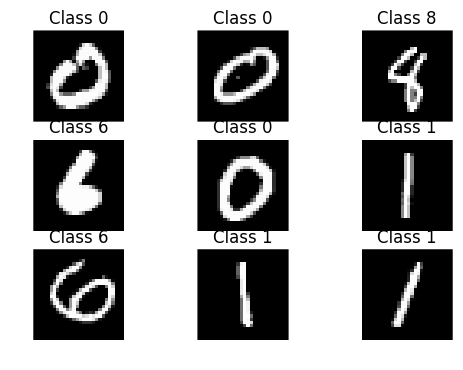

In [3]:
def plot_samples(X_train, y_train):
    f, ax = plt.subplots(3, 3)
    
    for i, col in enumerate(ax):
        for j, row in enumerate(col):
            index = random.randint(0, len(X_train))
            ax[i][j].axis("off")
            ax[i][j].imshow(X_train[index], cmap='gray', interpolation='none')
            ax[i][j].set_title("Class {}".format(y_train[index]))
            ax[i][j].axis("off")
        
plot_samples(X_train, y_train)

## 3. Define model

In [24]:
def get_model():
    
    image_shape = (28, 28, 1)
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=image_shape, output_shape=image_shape, name="input"))
    model.add(Convolution2D(3, 5, 5, subsample=(1, 1), border_mode="valid", activation='relu'))
    model.add(Convolution2D(6, 5, 5, subsample=(1, 1), border_mode="valid", activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax', name="output"))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## 5. Train model

In [8]:
def plot_metrics(history):
    keys = history.history.keys()

    for k in keys:
        plt.clf()
        plt.plot(history.history[k])
        plt.title("model " + k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.show()
        
def train_model(X_train, y_train, X_test, y_test):
    
    model = get_model()
    
    history = model.fit(X_train, y_train,
              batch_size=128, nb_epoch=4,
              verbose=1,
              validation_data=(X_test, y_test))
    
    model.save_weights("model.h5")
    with open("model.json", "w+") as outfile:
        json.dump(model.to_json(), outfile)

    plot_metrics(history)

def reshape_input(X):
    return np.expand_dims(X, axis=3)

X_trains, X_tests = reshape_input(X_train), reshape_input(X_test)
train_model(X_trains, y_train, X_tests, y_test)

## 6. Export
### 6.1 Get tensorflow graph

In order to be able to use the model in Android, it has to be a tensorflow model.

In [2]:
def export_tensor():
    with open("model.json", 'r') as jfile:
        new_model = model_from_json(json.loads(jfile.read()))\

    new_model.compile("adam", "sparse_categorical_crossentropy")
    new_model.load_weights("model.h5")

    ####################################################################
    K.set_learning_phase(0)
    

    export_path = "./"
    export_version = 1

    sess = tf.Session()
    init_op = tf.global_variables_initializer()

    saver = tf.train.Saver(sharded=True)
    sess.run(init_op)
    model_exporter = exporter.Exporter(saver)
    signature = exporter.classification_signature(input_tensor=new_model.input,
                                                  scores_tensor=new_model.output)
   
    model_exporter.init(sess.graph.as_graph_def(),
                        default_graph_signature=signature)

    model_exporter.export(export_path, tf.constant(export_version), sess)
    
    tf.train.write_graph(sess.graph_def, ".", "mnist.pb.txt")
    tf.train.write_graph(sess.graph_def, ".", "mnist.pb", as_text=False)
    
    # input_input  input images
    # output/Softmax output labels
    [print(n.name) for n in tf.get_default_graph().as_graph_def().node]

export_tensor()

INFO:tensorflow:./00000001-tmp/export is not in all_model_checkpoint_paths. Manually adding it.
input_input
input/truediv/y
input/truediv
input/sub/y
input/sub
conv2d_15/random_uniform/shape
conv2d_15/random_uniform/min
conv2d_15/random_uniform/max
conv2d_15/random_uniform/RandomUniform
conv2d_15/random_uniform/sub
conv2d_15/random_uniform/mul
conv2d_15/random_uniform
conv2d_15/kernel
conv2d_15/kernel/Assign
conv2d_15/kernel/read
conv2d_15/Const
conv2d_15/bias
conv2d_15/bias/Assign
conv2d_15/bias/read
conv2d_15/convolution/Shape
conv2d_15/convolution/dilation_rate
conv2d_15/convolution
conv2d_15/BiasAdd
conv2d_15/Relu
conv2d_16/random_uniform/shape
conv2d_16/random_uniform/min
conv2d_16/random_uniform/max
conv2d_16/random_uniform/RandomUniform
conv2d_16/random_uniform/sub
conv2d_16/random_uniform/mul
conv2d_16/random_uniform
conv2d_16/kernel
conv2d_16/kernel/Assign
conv2d_16/kernel/read
conv2d_16/Const
conv2d_16/bias
conv2d_16/bias/Assign
conv2d_16/bias/read
conv2d_16/convolution/Shape

### 6.2 Freeze graph

In [4]:
def freeze_graph():
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state("./00000001")
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_folder + "/frozen_mnist.pb"

    # Before exporting our graph, we need to precise what is our output node
    # This is how TF decides what part of the Graph he has to keep and what part it can dump
    # NOTE: this variable is plural, because you can have multiple output nodes
    output_node_names = "output/Softmax"
#     output_node_names = "iterations/initial_value"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True
    
    # We import the meta graph and retrieve a Saver
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    # We retrieve the protobuf graph definition
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    # We start a session and restore the graph weights
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            input_graph_def, # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())

        print("%d ops in the final graph." % len(output_graph_def.node))

freeze_graph()

INFO:tensorflow:Froze 10 variables.
Converted 10 variables to const ops.
50 ops in the final graph.


## 7. Evaluate

(10000, 28, 28, 1)
Test score: 0.0512515430097
 9984/10000 [============================>.] - ETA: 0s

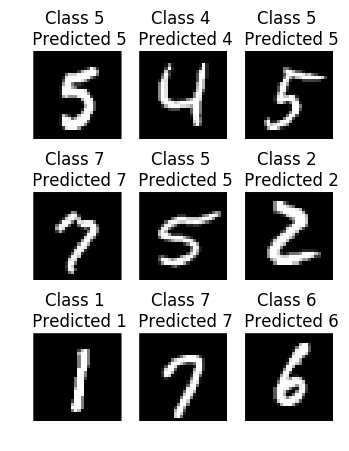

In [31]:
def evaluate(X, y):
    with open("model.json", 'r') as jfile:
        new_model = model_from_json(json.loads(jfile.read()))\

    new_model.compile("adam", "sparse_categorical_crossentropy")
    new_model.load_weights("model.h5")
    
    score = new_model.evaluate(X, y, verbose=0)
    print('Test score:', score)
    
    predicted_classes = new_model.predict_classes(X)
    correct_indices = np.nonzero(predicted_classes == y)[0]
    incorrect_indices = np.nonzero(predicted_classes != y)[0]
    
    f, ax = plt.subplots(3, 3)
    
    for i, col in enumerate(ax):
        for j, row in enumerate(col):
            index = random.randint(0, len(X))
            ax[i][j].axis("off")
            ax[i][j].imshow(X[index].squeeze(), cmap='gray', interpolation='none')
            ax[i][j].set_title("Class {} \n Predicted {}".format(y[index], predicted_classes[index]))
            ax[i][j].axis("off")
            
    plt.subplots_adjust(left=0., right=.5, top=2, bottom=1)

evaluate(X_tests, y_test)